<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_11_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

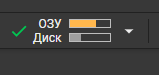


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка


### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Импортируем утилиты, для просмотре структуры модели
from tensorflow.keras import utils 

# Импортируем библиотеку numpy
import numpy as np 

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами 
import os 

# Для генерации случайных чисел 
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image 

# очистка ОЗУ
import gc 

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:22<00:00, 9.55MB/s]


## Решение

In [ ]:
# Ваше решение

 ### Зададим глобальные параметры

In [ ]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки 
IMG_HEIGHT = 192              # Высота картинки 
CLASS_COUNT = 16              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

### Служебные функции для работы с данными из учебного ноутбука

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

### Загрузка и предварительная обработка данных

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.62 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.04 с
Количество изображений: 100


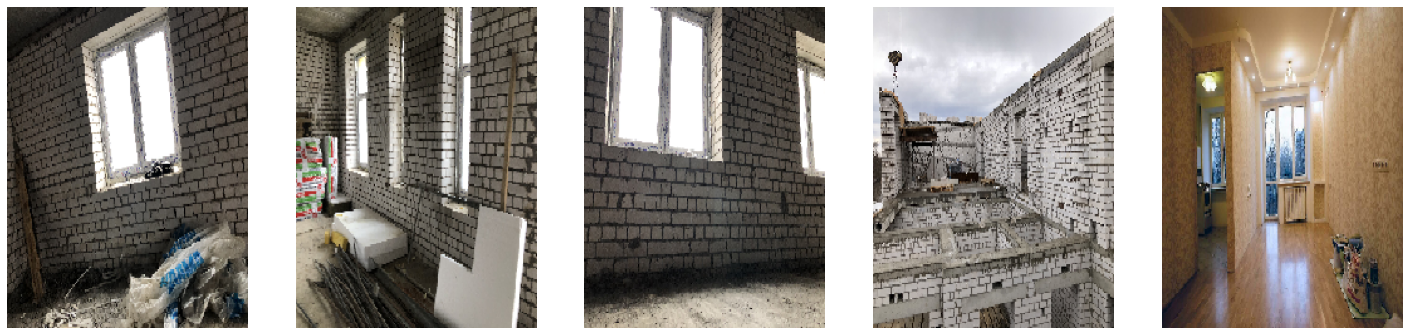

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.67 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.05 с
Количество изображений: 100


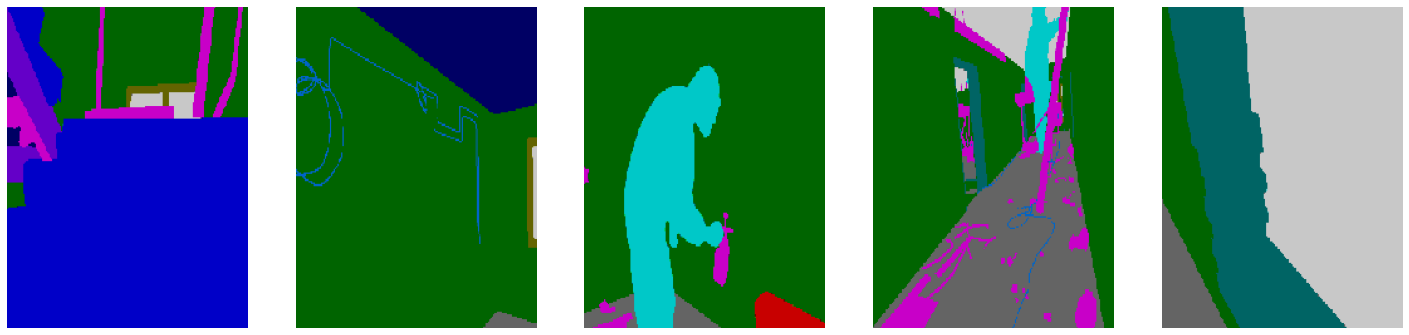

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

In [ ]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(1900, 256, 192, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(100, 256, 192, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 256, 192, 1)
(100, 256, 192, 1)


In [ ]:
# Преобразуем на основании задания из 16 параметров к 7
# создадим dictionary с новой маркировкой классов (первые три класса остаются неизменными, поэтому начинаем от 3)
new_nums = {
    3: 4,
    4: 3,
    5: 3,
    6: 3,
    7: 6,
    8: 4,
    9: 6,
    10: 6,
    11: 4,
    12: 5,
    13: 6,
    14: 6,
    15: 6
}

def map_labels(x):
    if x in new_nums:
        return new_nums[x]
    else:
        return x

vfunc = np.vectorize(map_labels)

In [ ]:
y_val7 = vfunc(y_val)
y_train7 = vfunc(y_train)

![pspnet[1].png](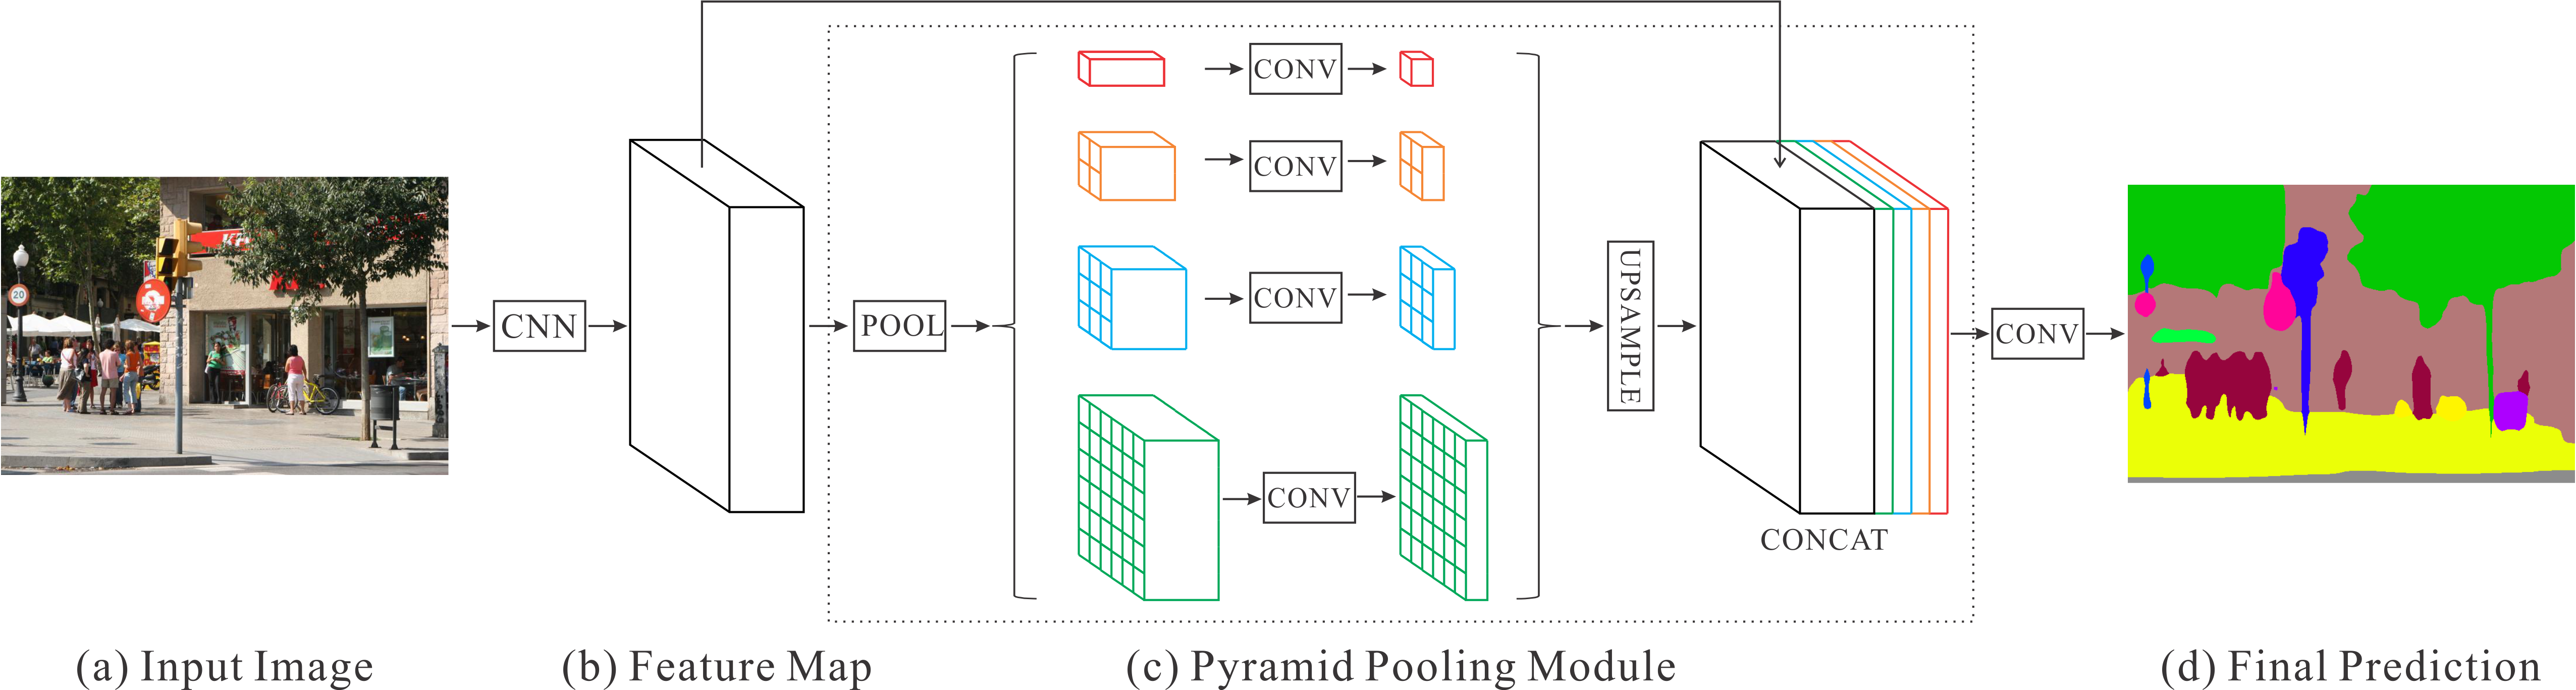)

In [ ]:
def PSPNet(input_shape=(256, 192, 3), filters = 128, kernel_size_main = (3,3), kernel_size_psp = (2,2), psp_layers = 16,num_classes=16, activ = 'relu'):

  # Подфункция для формирования PSPnet блока
  def pyramid_block(input,frame,filter,kernel,activ):
    x = MaxPooling2D(pool_size=frame)(input)                                
    x = Conv2D(filter, kernel, padding='same')(x)  
    x = BatchNormalization()(x)    
    x = Activation(activ)(x)     
    out = UpSampling2D(size=frame)(x)                      
    return out
  # находим минимальный размер картинки (weight/length)
  cnt = min(input_shape[0], input_shape[1]) 
  
  # подсчитываем максимальное количество слоев пирамиды
  layers_cnt = 0
  for i in range(1,psp_layers+1):
    if (2**i)<=cnt:
      layers_cnt += 1

  inputs = Input(shape=input_shape)

  # Начальный блок, предобработка
  x = Conv2D(filters,kernel_size_main, padding='same')(inputs)         
  x = BatchNormalization()(x)                                                       
  conv = Activation(activ)(x)

  # дополнительная предобработка, обходит psp блок
  x = Conv2D(int(filters/2),kernel_size_main, padding='same')(conv)         
  x = BatchNormalization()(x)                                                       
  conv_in = Activation(activ)(x)

  # Создаем список окон для PSPnet блока
  frames_pyramid = [2**i for i in range(1,layers_cnt)]

  features = []
   
  # Формируем блоки согласно списка
  for frame in frames_pyramid:
    pyramid_main = pyramid_block(conv,frame,filters,kernel_size_psp,activ)
    features.append(pyramid_main)
    
  # Соединяем полученные данные из разных блоков
  x = concatenate(features)
  x = Conv2D(filters, kernel_size_main, padding='same', name='conc_main')(x)       
  x = BatchNormalization()(x)
  conc_main = Activation(activ)(x)

  # Соединяем текущие данные с данными со входа
  conc = concatenate([conc_main,  conv_in])
  x = Conv2D(filters, kernel_size_main, padding='same')(conc)                            
  x = BatchNormalization()(x)                                              
  x = Activation(activ)(x)                                               
               
  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов
  x = Conv2D(num_classes, kernel_size_main, activation='softmax', padding='same')(x) 
    
  # Создаем модель с входом 'inputs' и выходом 'x'
  model = Model(inputs, x) 
  return model

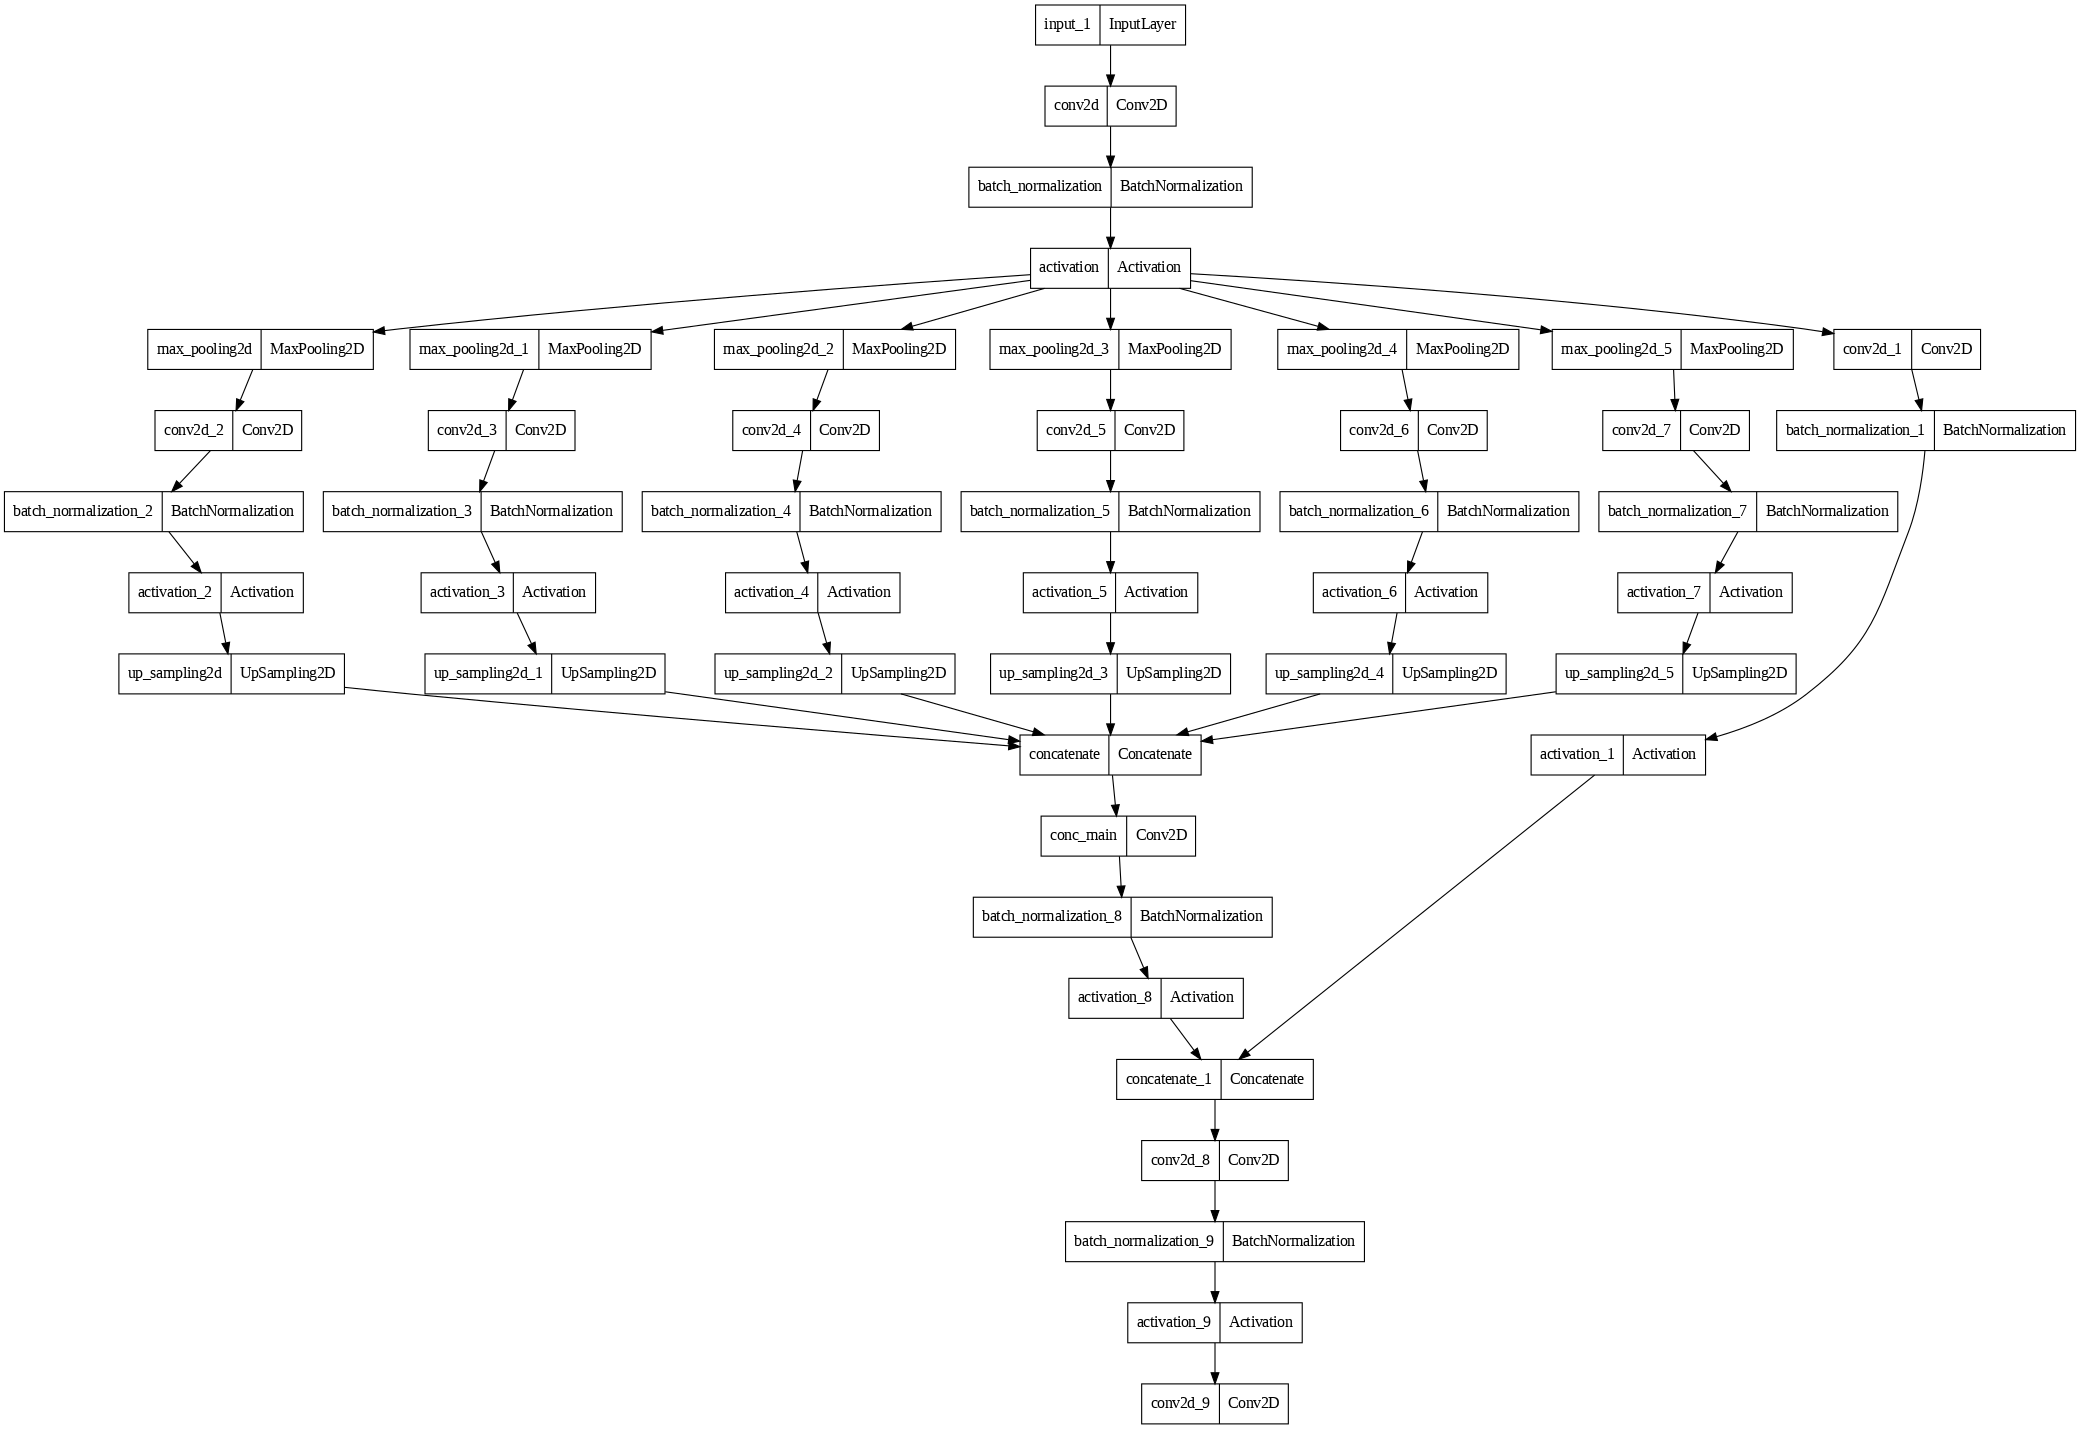

In [ ]:
model = PSPNet(input_shape = x_train[0].shape)
utils.plot_model(model, dpi=80)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 192, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 192, 12  512        ['conv2d[0][0]']                 
 alization)                     8)                                                            

In [ ]:
# Обучение модели
model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
history = model.fit(x_train, y_train7,
                         epochs=50, batch_size=12,
                         validation_data=(x_val, y_val7))

Epoch 1/50
159/159 [==============================] - 182s 946ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.6330 - val_loss: 1.8201 - val_sparse_categorical_accuracy: 0.4331
Epoch 2/50
159/159 [==============================] - 147s 927ms/step - loss: 0.9049 - sparse_categorical_accuracy: 0.6839 - val_loss: 1.4249 - val_sparse_categorical_accuracy: 0.5184
Epoch 3/50
159/159 [==============================] - 149s 934ms/step - loss: 0.8570 - sparse_categorical_accuracy: 0.7018 - val_loss: 1.1680 - val_sparse_categorical_accuracy: 0.5918
Epoch 4/50
159/159 [==============================] - 149s 935ms/step - loss: 0.8147 - sparse_categorical_accuracy: 0.7163 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.6040
Epoch 5/50
159/159 [==============================] - 149s 936ms/step - loss: 0.7915 - sparse_categorical_accuracy: 0.7231 - val_loss: 1.2345 - val_sparse_categorical_accuracy: 0.5874
Epoch 6/50
159/159 [==============================] - 149s 935ms/step - loss: 0.

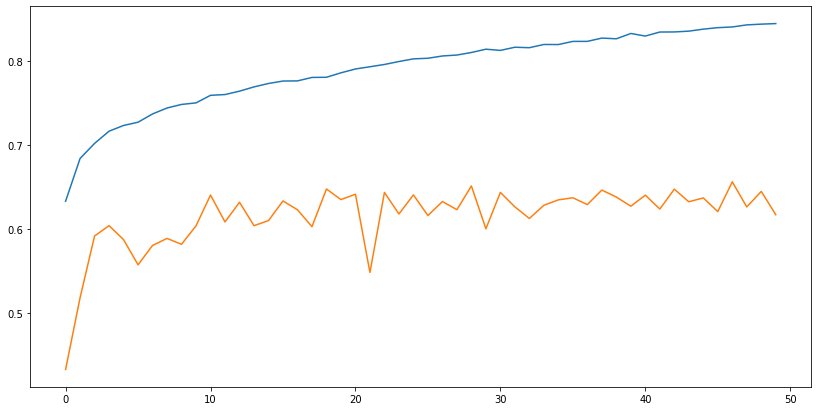

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)
    
    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15)) 
    
    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show() 

1/1 [==============================] - 3s 3s/step


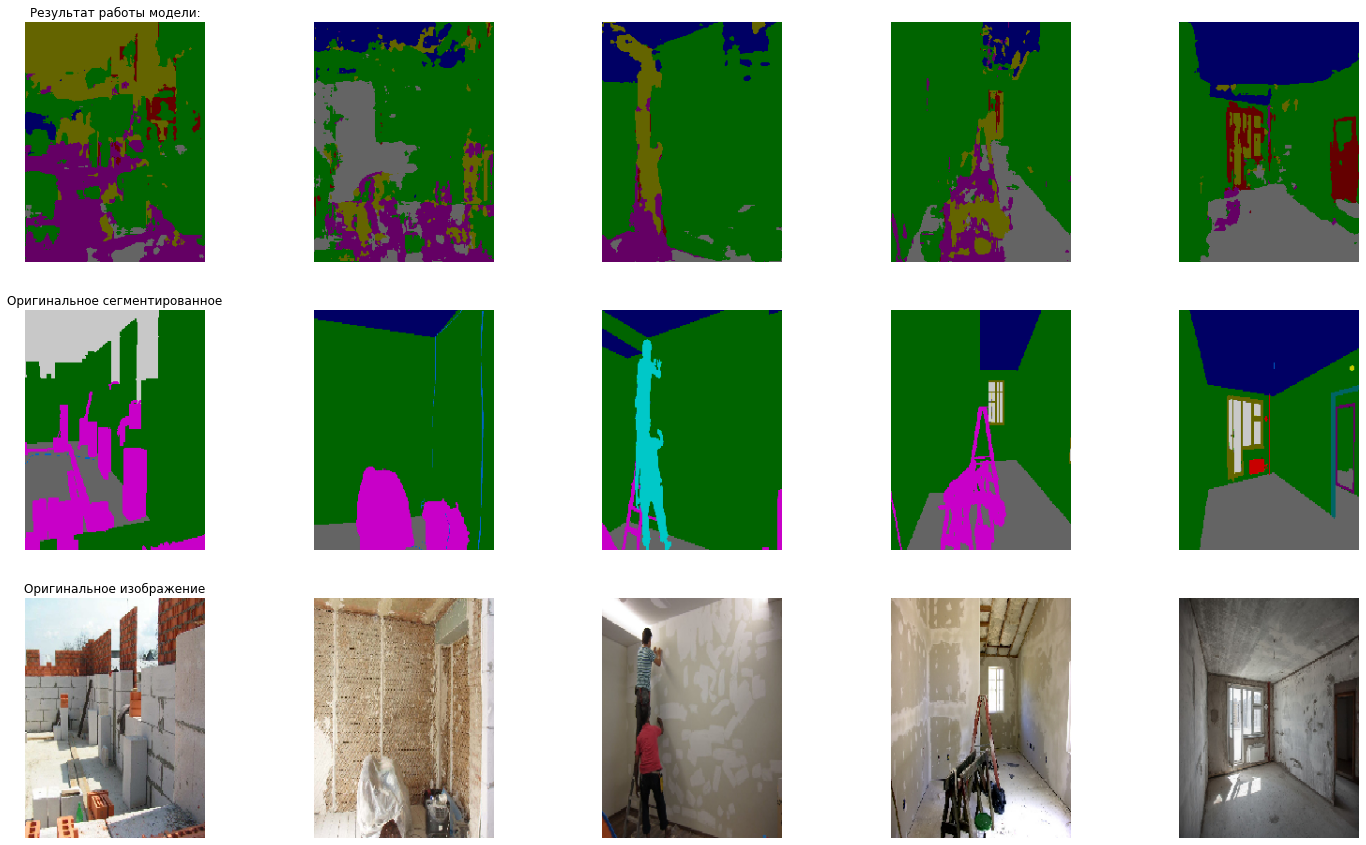

In [ ]:
# Отображение результатов работы модели

process_images(model, 5)

### Вывод:

Поставленная по условию задача выполнена, PSP модель создана и работоспособна. Как дополнение могу сказать что имеет смысл использовать в предобработке уже предобученные модели от Keras.